In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.7.0'

In [3]:
%run module.ipynb

## Data preprocessing

In [4]:
BATCH_SIZE = 32

In [5]:
image_input = sorted(tf.io.gfile.glob('./ISIC2018_Task1-2_Training_Input_x2/*.jpg'))
ground_truth = sorted(tf.io.gfile.glob('./ISIC2018_Task1_Training_GroundTruth_x2/*.png'))

In [6]:
image_input[:3]

['.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000000.jpg',
 '.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000001.jpg',
 '.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000003.jpg']

In [7]:
ground_truth[:3]

['.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0000000_segmentation.png',
 '.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0000001_segmentation.png',
 '.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0000003_segmentation.png']

In [8]:
index = np.random.permutation(len(image_input))
image_input = np.array(image_input)[index]
ground_truth = np.array(ground_truth)[index]

In [9]:
image_input[:3]

array(['.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0009298.jpg',
       '.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0014500.jpg',
       '.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0010086.jpg'],
      dtype='<U53')

In [10]:
ground_truth[:3]

array(['.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0009298_segmentation.png',
       '.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0014500_segmentation.png',
       '.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0010086_segmentation.png'],
      dtype='<U70')

In [11]:
# Divide the dataset into training set, validation set and test set with 7：2：1
length = len(image_input)
print(length)

image_input_val = image_input[:(int(length*0.2))]
print(len(image_input_val))
ground_truth_val = ground_truth[:(int(length*0.2))]
print(len(ground_truth_val))

2594
518
518


In [12]:
image_input_test = image_input[int(length*0.2):int(length*0.3)]
ground_truth_test = ground_truth[int(length*0.2):int(length*0.3)]

image_input_train = image_input[int(length*0.3):]
ground_truth_train = ground_truth[int(length*0.3):]

In [13]:
print(len(image_input_train))
print(len(ground_truth_train))

1816
1816


In [14]:
# To re-import train_ds, you need to start from this step
train_ds = tf.data.Dataset.from_tensor_slices((image_input_train, ground_truth_train))
val_ds = tf.data.Dataset.from_tensor_slices((image_input_val, ground_truth_val))
test_ds = tf.data.Dataset.from_tensor_slices((image_input_test, ground_truth_test))

In [15]:
# Image processing function
# choosing the image size of 192, 256
def processing_jpg(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (192, 256))
    
    return image
  
def processing_png(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, (192, 256))
    
    return image

In [16]:
# normalize function
def normal(image, ground):
    image = tf.cast(image, tf.float32) / 255.0
    ground = tf.cast(ground, tf.float32) / 255.0
    
    return image, ground

def load_image(image_path, ground_path):
    image = processing_jpg(image_path)
    ground = processing_png(ground_path)
    image, ground = normal(image, ground)

    return image, ground

In [17]:
train_ds = train_ds.map(load_image)
val_ds = val_ds.map(load_image)
test_ds = test_ds.map(load_image)

In [18]:
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [19]:
test_ds

<BatchDataset shapes: ((None, 192, 256, 3), (None, 192, 256, 1)), types: (tf.float32, tf.float32)>

## Construct related functions

In [20]:
def dice_coef(y_true, y_pred, smooth = 1.0):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_coef_result = (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

    return dice_coef_result

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [21]:
def plot_dice_and_loss(history):
    dice = history.history['dice_coef']
    val_dice = history.history['val_dice_coef']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(20)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, dice, label='Training Dice')
    plt.plot(epochs_range, val_dice, label='Validation Dice')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Dice Coefficient')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [22]:
def plot_prediction_images(model, test_ds, n = 3):
    X_test, y_test = next(iter(test_ds))
    y_pred = model.predict(X_test)
    
    FONT_SIZE = 18
    
    plt.figure(figsize=(14, 14))
    for i in range(n):
        plt.subplot(n, 3, i*3+1)
        plt.imshow(X_test[i])
        plt.axis('off')
        plt.title("Image", size=FONT_SIZE)

        plt.subplot(n, 3, i*3+2)

        plt.imshow(y_pred[i])
        plt.gray()
        plt.axis('off')
        plt.title("Prediction", size=FONT_SIZE)

        plt.subplot(n, 3, i*3+3)
        plt.imshow(y_test[i])
        plt.gray()
        plt.axis('off')
        plt.title("Original_Result", size=FONT_SIZE)
    plt.show()

## Compiling and training the model

In [23]:
model = improved_model()
model.compile(optimizer="adam", loss=dice_coef_loss, metrics=[dice_coef])

In [24]:
# model.summary()

In [25]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 20)

Epoch 1/20
57/57 [==============================] - 22s 255ms/step - loss: 0.5705 - dice_coef: 0.4300 - val_loss: 0.4604 - val_dice_coef: 0.5382
Epoch 2/20
57/57 [==============================] - 12s 217ms/step - loss: 0.4208 - dice_coef: 0.5793 - val_loss: 0.3809 - val_dice_coef: 0.6204
Epoch 3/20
57/57 [==============================] - 13s 219ms/step - loss: 0.3219 - dice_coef: 0.6783 - val_loss: 0.2837 - val_dice_coef: 0.7170
Epoch 4/20
57/57 [==============================] - 12s 215ms/step - loss: 0.2216 - dice_coef: 0.7785 - val_loss: 0.2104 - val_dice_coef: 0.7901
Epoch 5/20
57/57 [==============================] - 12s 215ms/step - loss: 0.1819 - dice_coef: 0.8182 - val_loss: 0.1948 - val_dice_coef: 0.8054
Epoch 6/20
57/57 [==============================] - 12s 214ms/step - loss: 0.1653 - dice_coef: 0.8347 - val_loss: 0.1887 - val_dice_coef: 0.8106
Epoch 7/20
57/57 [==============================] - 13s 221ms/step - loss: 0.1570 - dice_coef: 0.8430 - val_loss: 0.1644 - val_dic

## Test the prediction results and the dice coefficient of the model 

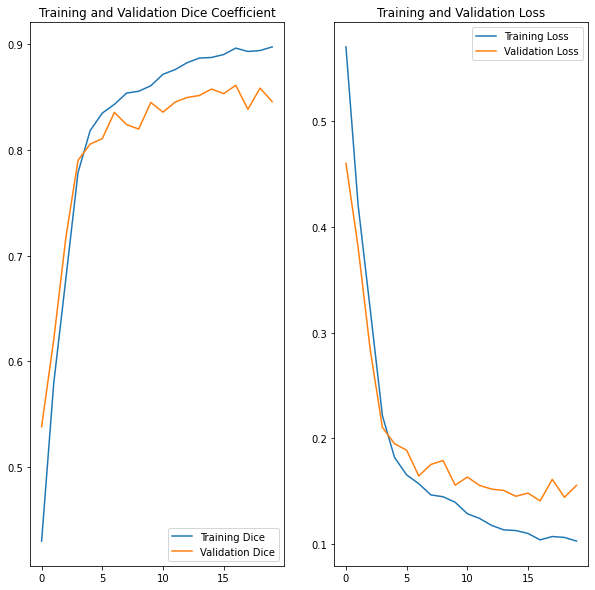

In [26]:
plot_dice_and_loss(history)

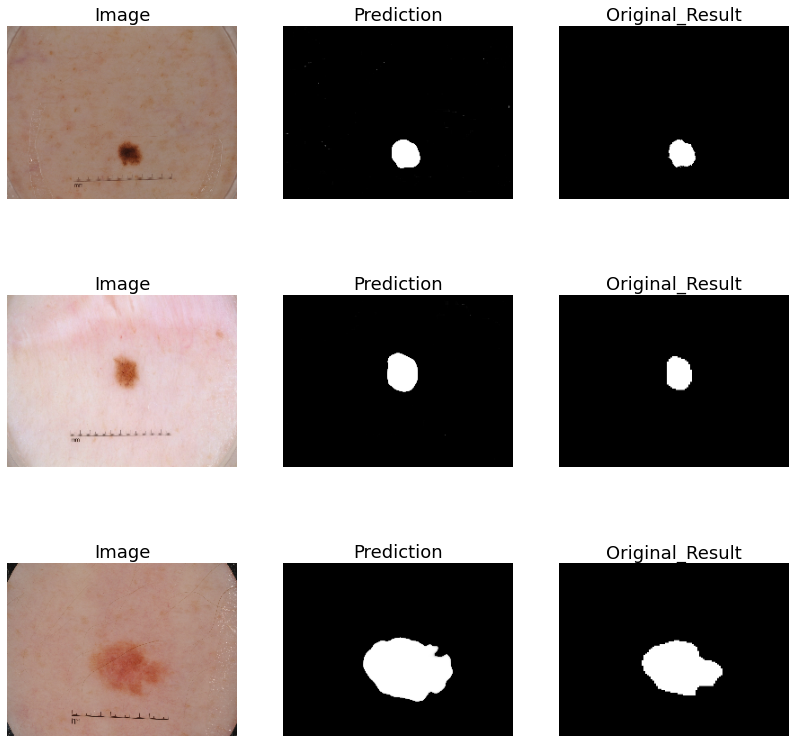

In [27]:
plot_prediction_images(model, test_ds)

In [28]:
pred_result = model.evaluate(test_ds, verbose=1)

9/9 [==============================] - 1s 89ms/step - loss: 0.1316 - dice_coef: 0.8623
